## Imports

In [1]:
import os
import pandas as pd
import numpy as np
import tarfile
import matplotlib.pyplot as plt
import spacy

import re
from nltk.tokenize import word_tokenize
from collections import Counter
from wordcloud import WordCloud
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from textblob import TextBlob

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

## Dataset Exploration

In [2]:
# Extract the dataset
tar = tarfile.open("/content/drive/MyDrive/datasets/20_newsgroups.tar.gz")
tar.extractall()
tar.close()

In [51]:
# Define the directory containing the extracted dataset
dataset_dir = "./20_newsgroups"

# Initialize variables to count observations, newsgroups, and files
total_observations = 0
total_newsgroups = 0
observations_per_group = {}

# Traverse through the directory structure
for category in os.listdir(dataset_dir):
    category_path = os.path.join(dataset_dir, category)
    # Check if the category is a directory (newsgroup)
    if os.path.isdir(category_path):
        total_newsgroups += 1
        # Count the number of files (observations) in each newsgroup
        category_files = os.listdir(category_path)
        num_observations = len(category_files)
        observations_per_group[category] = num_observations
        # Increment the total number of observations
        total_observations += num_observations

# Calculate the size of the data
data_size = sum(os.path.getsize(os.path.join(root, file))
                for root, _, files in os.walk(dataset_dir)
                for file in files)

# Print the summary statistics
print("Dataset Exploration")
print("\nTotal number of observations:", total_observations)
print("\nTotal number of newsgroups:", total_newsgroups)
print("\nNumber of observations per newsgroup:")
for group, num_observations in observations_per_group.items():
    print(f"{group}: {num_observations}")
print("\nSize of the data (in bytes):", data_size)

Dataset Exploration

Total number of observations: 19997

Total number of newsgroups: 20

Number of observations per newsgroup:
rec.autos: 1000
alt.atheism: 1000
sci.electronics: 1000
comp.os.ms-windows.misc: 1000
sci.med: 1000
talk.politics.guns: 1000
rec.sport.hockey: 1000
soc.religion.christian: 997
sci.crypt: 1000
comp.windows.x: 1000
comp.graphics: 1000
comp.sys.mac.hardware: 1000
talk.politics.misc: 1000
rec.sport.baseball: 1000
comp.sys.ibm.pc.hardware: 1000
talk.religion.misc: 1000
rec.motorcycles: 1000
sci.space: 1000
talk.politics.mideast: 1000
misc.forsale: 1000

Size of the data (in bytes): 46132928


This balanced distribution ensures that there is no bias towards any particular category during the analysis.

## Data Preprocessing

In [52]:
# Initialize an empty list to store newsgroups and content
data = []

# Traverse through the directory structure
for category in os.listdir(dataset_dir):
    category_path = os.path.join(dataset_dir, category)
    # Iterate through files in each category
    for file_name in os.listdir(category_path):
        file_path = os.path.join(category_path, file_name)
        # Read the content of the file
        with open(file_path, 'r', errors='ignore') as file:
            content = file.read()
            # Append newsgroup and content to the list
            data.append((category, content))

# Create a DataFrame from the list of newsgroups and content
df = pd.DataFrame(data, columns=['Newsgroup', 'Original_Content'])
df

Newsgroup                                   Original_Content
0         rec.autos  Path: cantaloupe.srv.cs.cmu.edu!magnesium.club...
1         rec.autos  Path: cantaloupe.srv.cs.cmu.edu!rochester!roch...
2         rec.autos  Path: cantaloupe.srv.cs.cmu.edu!das-news.harva...
3         rec.autos  Path: cantaloupe.srv.cs.cmu.edu!das-news.harva...
4         rec.autos  Newsgroups: rec.autos\nPath: cantaloupe.srv.cs...
...             ...                                                ...
19992  misc.forsale  Xref: cantaloupe.srv.cs.cmu.edu rec.audio:6319...
19993  misc.forsale  Path: cantaloupe.srv.cs.cmu.edu!rochester!udel...
19994  misc.forsale  Newsgroups: misc.forsale,misc.forsale.computer...
19995  misc.forsale  Path: cantaloupe.srv.cs.cmu.edu!das-news.harva...
19996  misc.forsale  Xref: cantaloupe.srv.cs.cmu.edu rec.games.boar...

[19997 rows x 2 columns]

In [53]:
# Check DataFrame information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19997 entries, 0 to 19996
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Newsgroup         19997 non-null  object
 1   Original_Content  19997 non-null  object
dtypes: object(2)
memory usage: 312.6+ KB


In [54]:
# Check for null values
df.isnull().sum()

Newsgroup           0
Original_Content    0
dtype: int64

In [55]:
# Check the shape of the dataset
print("Shape of the DataFrame:", df.shape)

Shape of the DataFrame: (19997, 2)


In [56]:
print(df["Original_Content"][1500])

Newsgroups: alt.atheism
Path: cantaloupe.srv.cs.cmu.edu!magnesium.club.cc.cmu.edu!news.sei.cmu.edu!cis.ohio-state.edu!zaphod.mps.ohio-state.edu!howland.reston.ans.net!usenet.ins.cwru.edu!agate!doc.ic.ac.uk!uknet!mcsun!news.funet.fi!ousrvr.oulu.fi!kempmp
From: kempmp@phoenix.oulu.fi (Petri Pihko)
Subject: Re: Consciousness part II - Kev Strikes Back!
Message-ID: <1993Apr22.011004.5580@ousrvr.oulu.fi>
Sender: news@ousrvr.oulu.fi
Organization: University of Oulu, Finland
X-Newsreader: TIN [version 1.1 PL9]
References: <1993Apr21.190656.986@news.wesleyan.edu>
Date: Thu, 22 Apr 1993 01:10:04 GMT
Lines: 30

Scott D. Sauyet (SSAUYET@eagle.wesleyan.edu) wrote:
> In <1993Apr21.163848.8099@cs.nott.ac.uk> 
> Kevin Anthony (kax@cs.nott.ac.uk) writes:

> > Firstly, I'm not impressed with the ability of algorithms. They're
> > great at solving problems once the method has been worked out, but not
> > at working out the method itself.
>   [ .. crossword example deleted ... ]

> Have you heard of neur

## Text Preprocessing

In [27]:
def preprocess_text(text):
    # Remove metadata headers
    text = re.sub(r'^.*?:.*?\n', '', text, flags=re.MULTILINE)

    # Remove emails
    text = re.sub(r'\S*@\S*\s?', '', text)

    # Remove numbers
    text = re.sub(r'\d+', '', text)

    # Remove 'GMT'
    text = re.sub(r'GMT', '', text)

    # Tokenization
    tokens = word_tokenize(text)

    # Lowercasing
    tokens = [token.lower() for token in tokens]

    # Removing Punctuation and non-alphabetic characters
    tokens = [token for token in tokens if token.isalpha()]

    # Remove single characters
    tokens = [token for token in tokens if len(token) > 1]

    # Removing Stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]

    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]

    # Join tokens back into a string
    preprocessed_text = ' '.join(tokens)

    return preprocessed_text

- Remove metadata headers: Metadata headers are removed using regular expressions. This step removes lines that start with any characters followed by a colon and any characters until a newline character \n. This is used to remove headers like "From:", "Subject:", etc.

- Remove emails: It matches any sequence of non-whitespace characters followed by an "@" symbol and then again any sequence of non-whitespace characters. This helps in removing email addresses which may not be relevant for text analysis.

- Remove numbers: Regular expression \d+ is used to match and remove any sequence of digits from the text. This is done to remove numerical digits which may not be relevant for text analysis or could introduce noise.

- Remove 'GMT': The string 'GMT' is removed from the text. This is done to remove timestamps or time zone indicators which may not be relevant for text analysis.

- Tokenization: The text is tokenized into individual words using the word_tokenize function from the NLTK library. Tokenization is the process of splitting text into smaller units, such as words or phrases.

- Lowercasing: All tokens are converted to lowercase using list comprehension. This ensures that words are treated consistently regardless of their original casing.

- Removing Punctuation and non-alphabetic characters: Tokens that contain only alphabetic characters are retained, while tokens containing any non-alphabetic characters (such as punctuation marks) are removed. This step helps in removing noise from the text data.

- Remove single characters: Tokens with a length of 1 (single characters) are removed. This is done to filter out single letters or other very short words that may not carry much semantic meaning.

- Removing Stopwords: Stopwords, which are commonly occurring words that do not carry much significance (e.g., 'the', 'is', 'and'), are removed from the tokens using a predefined set of stopwords from the NLTK library.

- Lemmatization: Each token is lemmatized using WordNetLemmatizer from NLTK, which reduces words to their base or dictionary form. This helps in standardizing tokens and reducing the dimensionality of the feature space.

- Join tokens back into a string: Finally, the preprocessed tokens are joined back into a single string, separated by whitespace, and returned as the preprocessed text.

Overall, these preprocessing steps aim to clean and standardize the text data, making it more suitable for text analysis tasks such as classification or clustering.

In [28]:
# Apply preprocessing function to the 'Original_Content' column
df['Content_prep'] = df['Original_Content'].apply(preprocess_text)

In [29]:
df["Content_prep"][1500]

'firstly impressed ability algorithm great solving problem method worked working method crossword example deleted heard neural network read little seems overcome objection sure many people work neural network read newsgroup please tell kevin achieved expect saying nns solve problem think show hard think come mechanical model consciousness indeed think dualism dennett recently put dead horse petri petri pihko mathematics truth pihatie physic rule oulu game finland chemistry game'

In [30]:
df["Content_prep"][100]

'arctic wheel fairbanks present th anniversary auto show auto show held may mother day weekend fort jonathan wainwright physical fitness center almost every vehicle welcome car truck snowmobile motorcycle antique racing etc welcome information call may also write arctic wheel fairbanks alaska show benefit alaska crippled child adult acca wish place vehicle show register early space limited first come first get spot show may also use id forward information show official university alaska fairbanks university alaska computer network james jim grime tenth anniversary auto show may presented arctic wheel benefit alaska crippled child adult call write auto show po box fairbanks ak'

In [31]:
df["Content_prep"][880]

'want thank people responded post week ago buying chev nova mi decided buy car month replaced front brake pad changed oil far problem surfaced received many suggestion encouragement purchase figured late thank better none thanks jim'

In [32]:
df["Content_prep"][8000]

'sick part really liked phrase actually merely threat long prison sentence even without beating get people give especially also punctuated trip county jail one happens get locked folk violent left cell people'

In [33]:
df["Content_prep"][18500]

'cjh stuff deleted saying conflict started one side aggressive ither always suffering sad still trying compromise remember action turkish government removing visa requirement greek come turkey thought positive attempt make relation better thought smart move receive money greek tourist bet week tourist greece turkey one leave least go figure mean economy kept visa requirement many greek would bother visit turkey smart indeed saying true greek visit happy turkish merchant happy harmed one smart move also good move add happiness greek per week however many turkish merchant interact one simple move paperwork arena lotsa happy people nationality observation cheer bm stuff deleted'

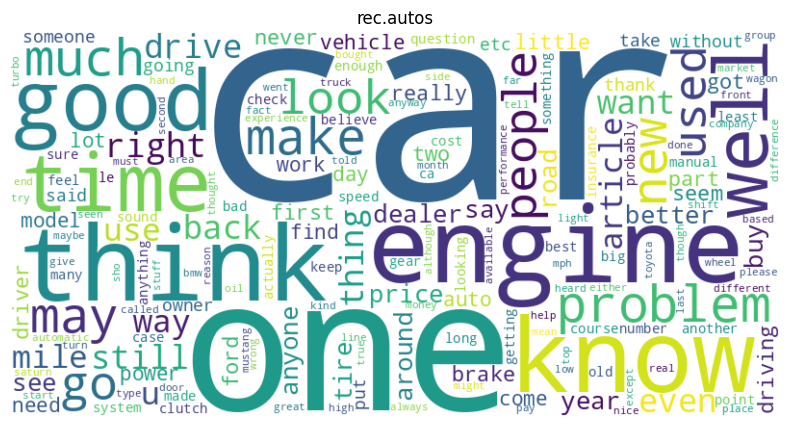

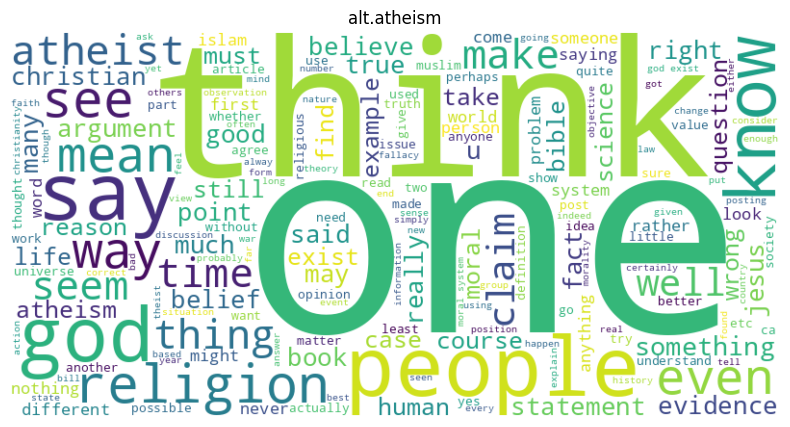

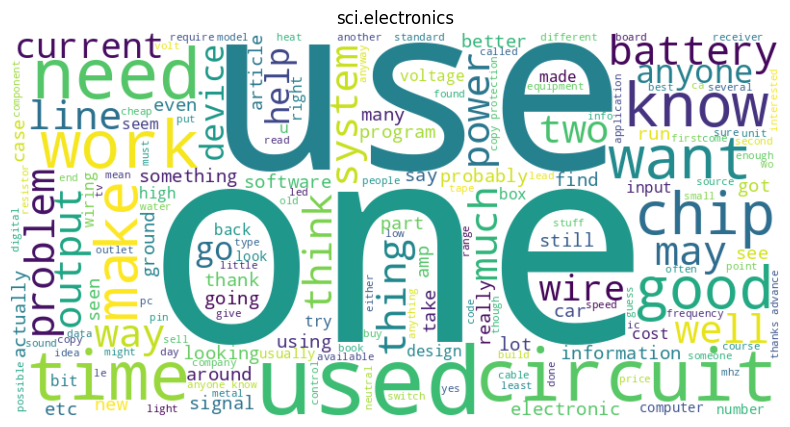

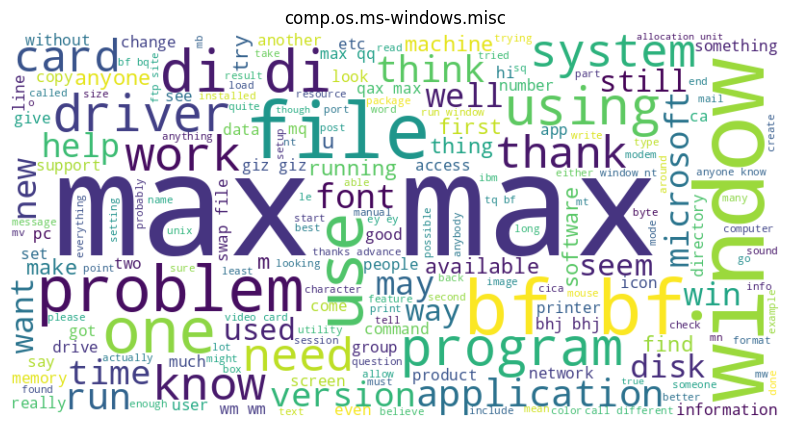

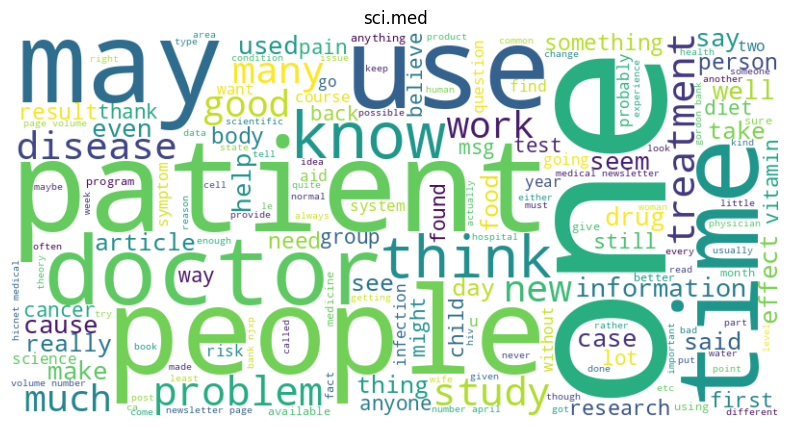

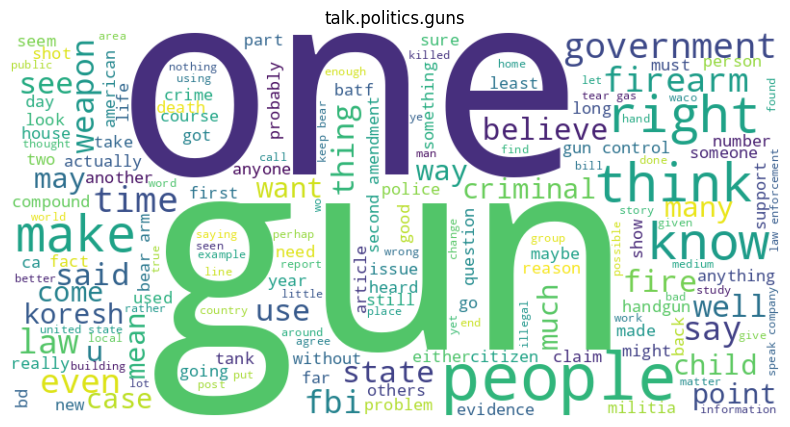

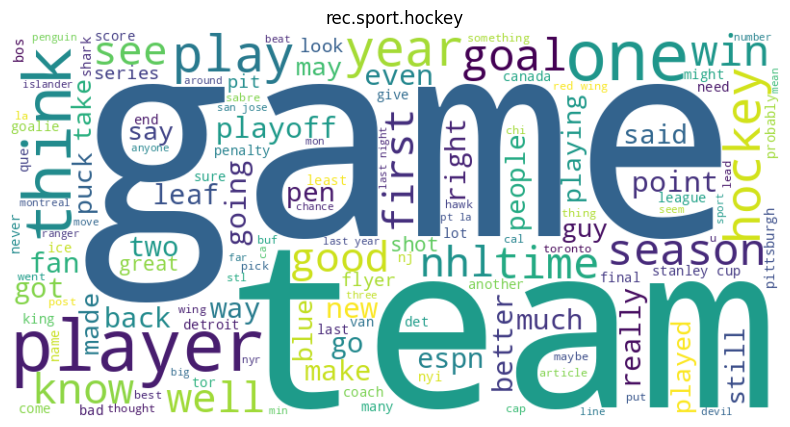

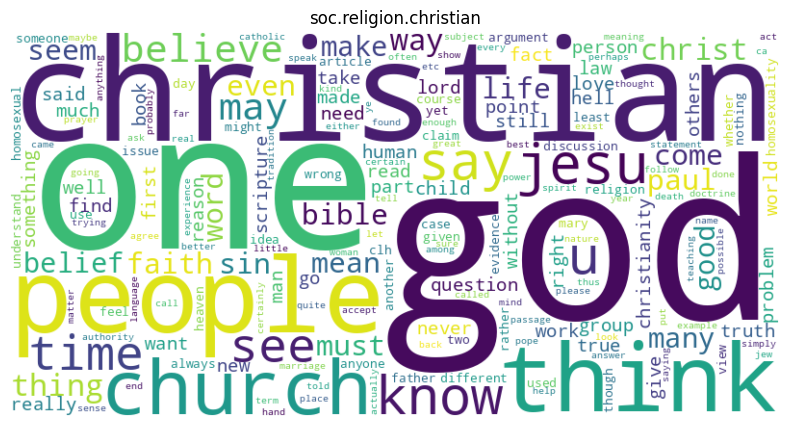

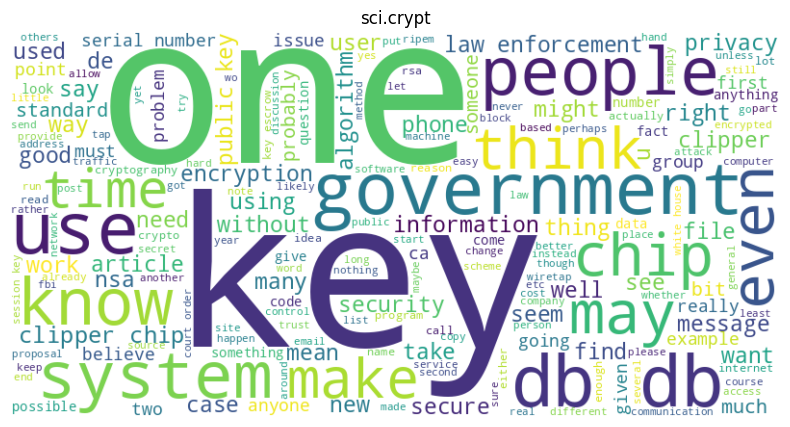

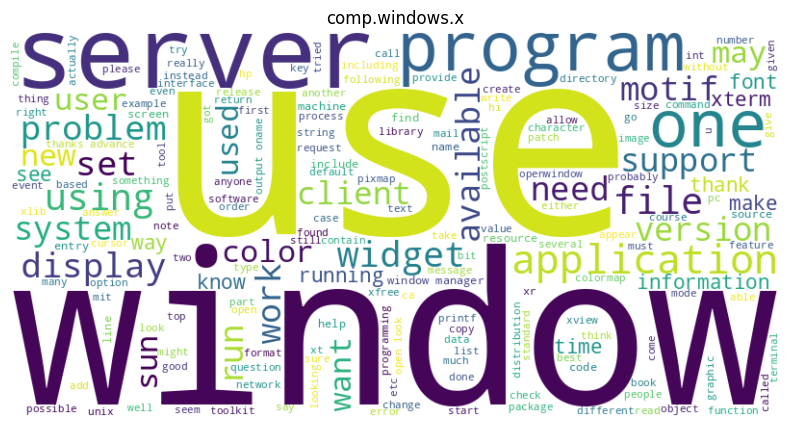

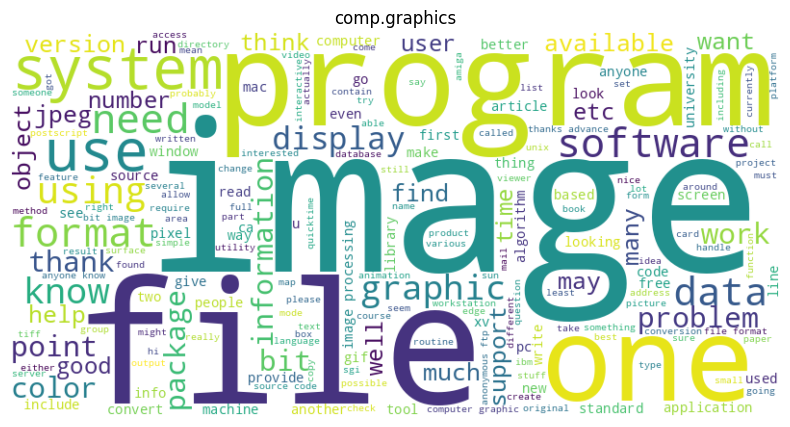

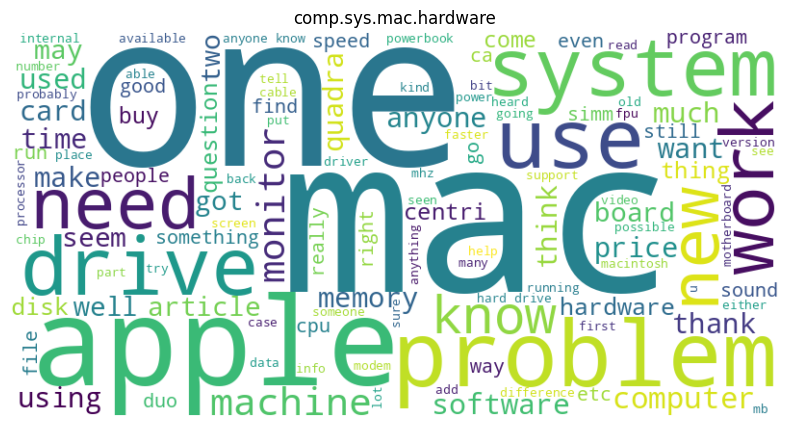

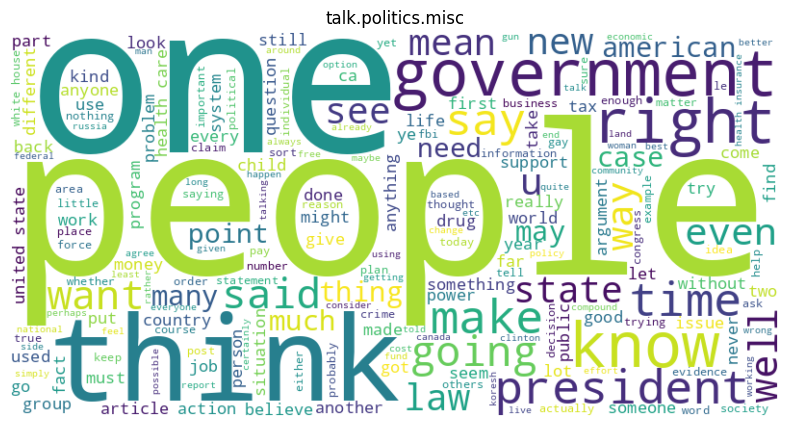

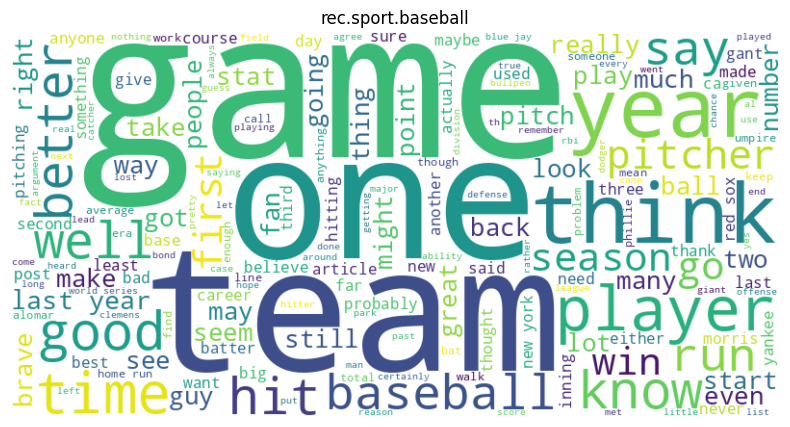

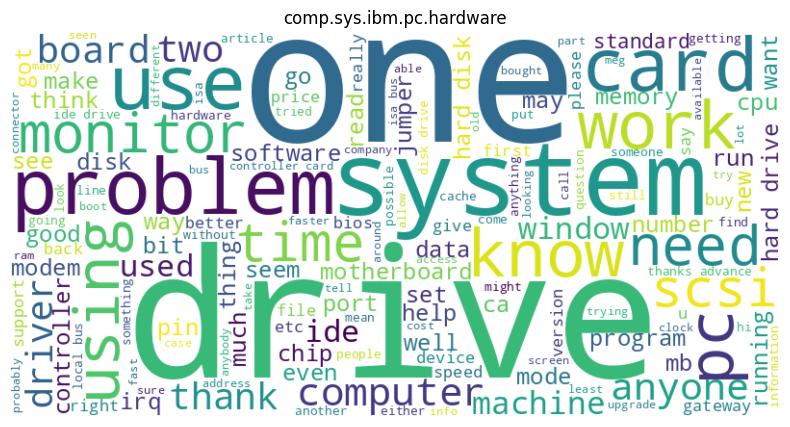

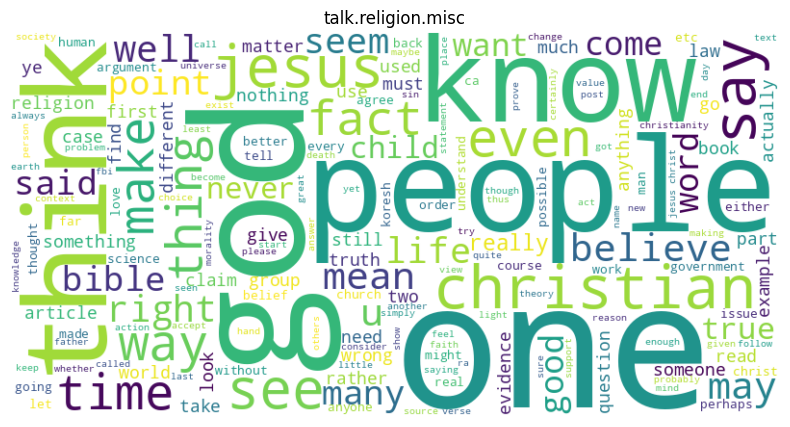

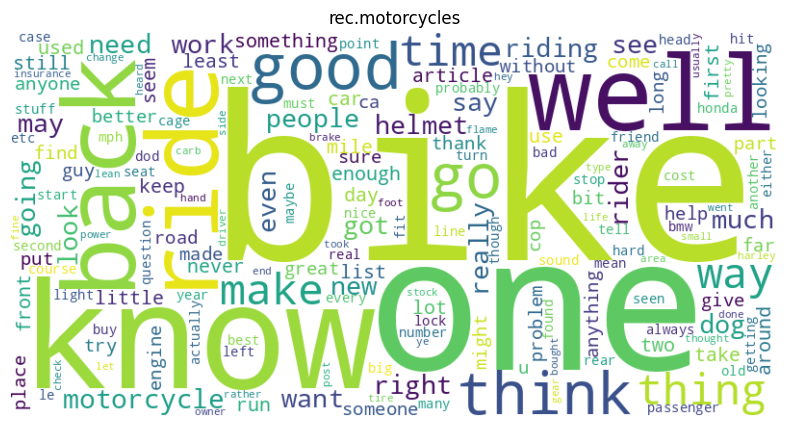

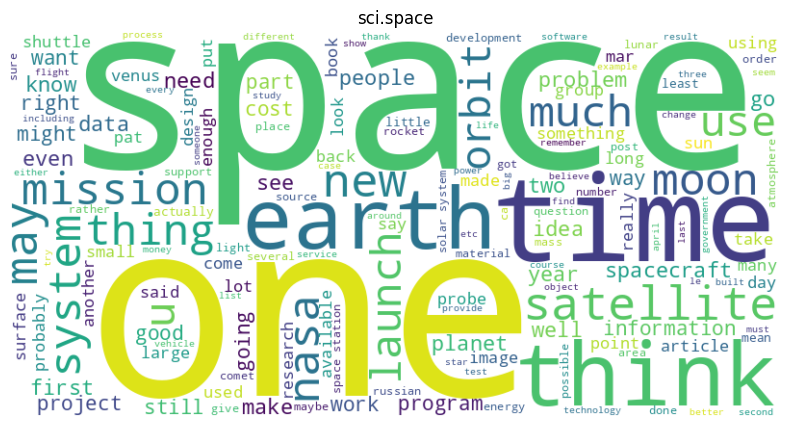

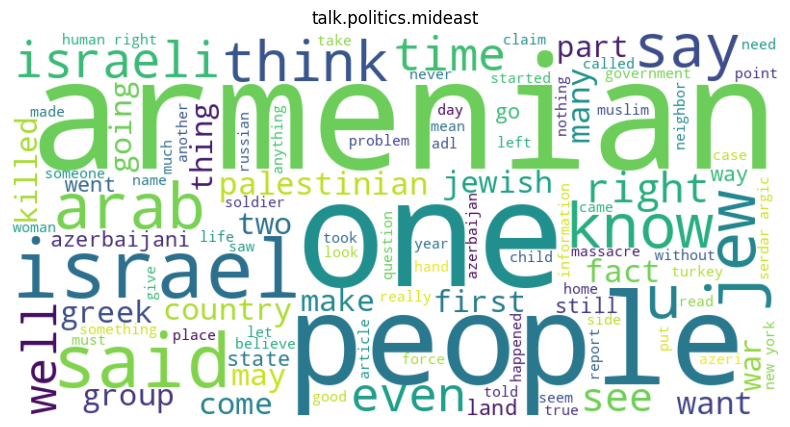

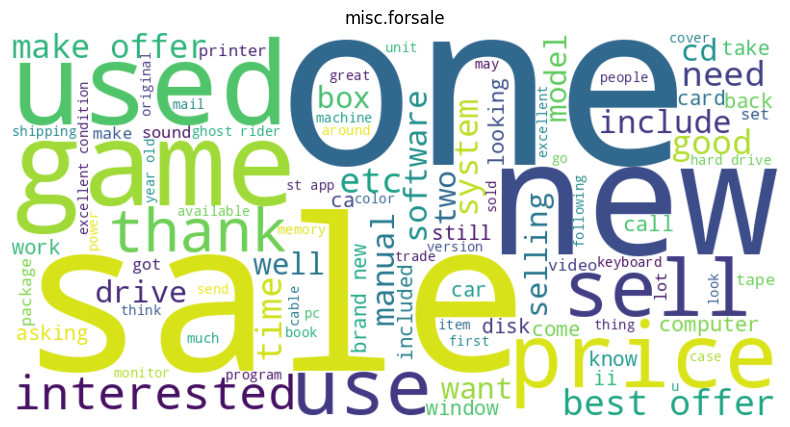

In [34]:
# Generate WordCloud for each Newsgroup
for group in df['Newsgroup'].unique():
    text = ' '.join(df[df['Newsgroup'] == group]['Content_prep'])
    wordcloud = WordCloud(width=800, height=400, background_color ='white', min_font_size = 10).generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(group)
    plt.axis('off')
    plt.show()

## Text Preprocessing using SpaCy

In [36]:
# Load the spaCy English model
nlp = spacy.load("en_core_web_sm")

In [37]:
def preprocess_text_spacy(text):
    # Remove metadata headers
    text = re.sub(r'^.*?:.*?\n', '', text, flags=re.MULTILINE)

    # Remove emails
    text = re.sub(r'\S*@\S*\s?', '', text)

    # Remove numbers
    text = re.sub(r'\d+', '', text)

    # Remove 'GMT'
    text = re.sub(r'GMT', '', text)

    # Remove extra whitespace and newline characters
    text = re.sub(r'\s+', ' ', text)

    # Apply spaCy tokenization and lemmatization
    doc = nlp(text)

    # Lemmatize tokens, lowercase and remove stopwords, punctuation and special characters
    tokens = [token.lemma_.lower() for token in doc if not token.is_stop and not token.is_punct and token.text.isalnum()]

    # Join tokens back into a string
    preprocessed_text = ' '.join(tokens)

    return preprocessed_text

In [38]:
# Apply spaCy preprocessing to the 'Content' column
df['Content_spacy'] = df['Original_Content'].apply(preprocess_text_spacy)

In [39]:
df['Content_spacy'][1500]

'firstly impressed ability algorithm great solve problem method work work method crossword example delete hear neural network read little overcome objection sure people work neural network read newsgroup tell kevin achieve expect say nn solve problem think hard think come mechanical model consciousness think dualism non solution dennett recently dead horse petri petri pihko mathematics truth pihatie c physics rule oulu game finland chemistry game'

In [40]:
df['Content_spacy'][100]

'arctic wheels fairbanks present th anniversary auto auto hold mother day weekend fort jonathan wainwright physical fitness center vehicle welcome car truck snowmobile motorcycle antique racing etc welcome information write arctic wheels fairbanks alaska benefit alaska crippled children adult acca wish place vehicle register early space limited come spot use id forward information official university alaska fairbanks university alaska computer network james jim grime tenth anniversary auto present arctic wheels benefit alaska cripple child adults write auto po box fairbanks ak'

In [41]:
df['Content_spacy'][880]

'want thank people respond post week ago buy chev nova mi decide buy car month replace brake pad change oil far problem surface receive suggestion encouragement purchase figure late thank well thank jim'

In [42]:
df['Content_spacy'][8000]

'sick like phrase actually merely threat long prison sentence beating people especially punctuate trip county jail happen lock drunk stone crazy folk violent leave cell people'

In [43]:
df['Content_spacy'][18500]

'cjh stuff delete say conflict start aggressive ither suffer sad try compromise remember action turkish government remove visa requirement greek come turkey think positive attempt relation well think smart receive money greek tourist bet week tourist greece turkey leave figure mean economy keep visa requirement greek bother visit turkey smart say true greeks visit happy turkish merchant happy harm smart good add happiness greek week turkish merchant interact simple paperwork arena lotsa happy people nationality observation cheer bm stuff delete'

## Comparison of the two methods

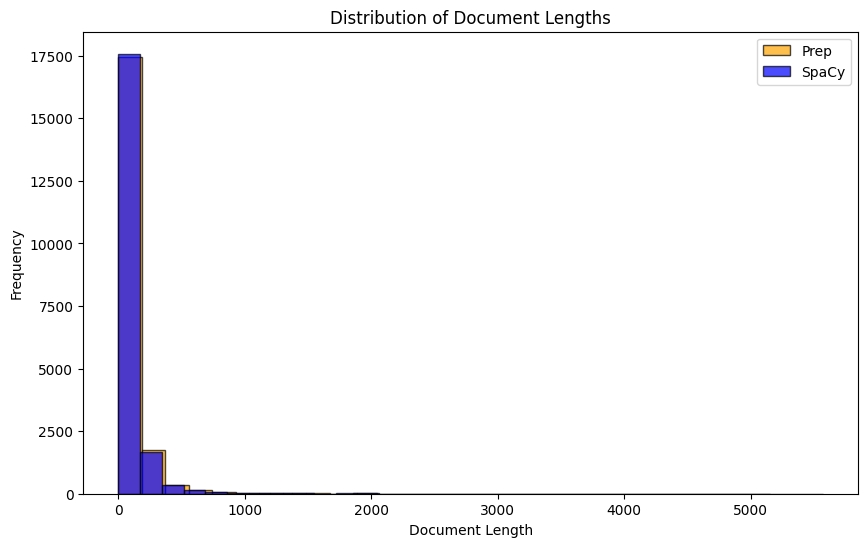

In [44]:
# Visualize Document Length Distribution
df['Prep_Document_Length'] = df['Content_prep'].apply(lambda x: len(x.split()))
df['SpaCy_Document_Length'] = df['Content_spacy'].apply(lambda x: len(x.split()))

plt.figure(figsize=(10, 6))
plt.hist(df['Prep_Document_Length'], bins=30, color='orange', edgecolor='black', alpha=0.7, label='Prep')
plt.hist(df['SpaCy_Document_Length'], bins=30, color='blue', edgecolor='black', alpha=0.7, label='SpaCy')
plt.title('Distribution of Document Lengths')
plt.xlabel('Document Length')
plt.ylabel('Frequency')
plt.legend()
plt.show()

In [46]:
# Display most common words
word_counter = Counter()
for content in df['Content_prep']:
    words = content.split()
    word_counter.update(words)

most_common_words = word_counter.most_common(20)
print("\nMost Common Words in Preprocessed Content:", most_common_words)

word_counter = Counter()
for content in df['Content_spacy']:
    words = content.split()
    word_counter.update(words)

most_common_words = word_counter.most_common(20)
print("\nMost Common Words in SpaCy Content:", most_common_words)


Most Common Words in Preprocessed Content: [('would', 16216), ('one', 15072), ('people', 9881), ('like', 9479), ('know', 9084), ('get', 8754), ('time', 7730), ('think', 7646), ('also', 7117), ('could', 6510), ('use', 6416), ('make', 6262), ('say', 5999), ('right', 5878), ('good', 5600), ('year', 5568), ('way', 5507), ('even', 5503), ('system', 5451), ('new', 5370)]

Most Common Words in SpaCy Content: [('know', 10850), ('people', 9919), ('like', 9741), ('think', 9405), ('x', 8369), ('time', 7830), ('good', 7492), ('use', 7267), ('say', 6743), ('work', 6190), ('right', 5832), ('year', 5681), ('want', 5675), ('go', 5671), ('new', 5616), ('way', 5580), ('come', 5368), ('thing', 5339), ('look', 5261), ('find', 5128)]


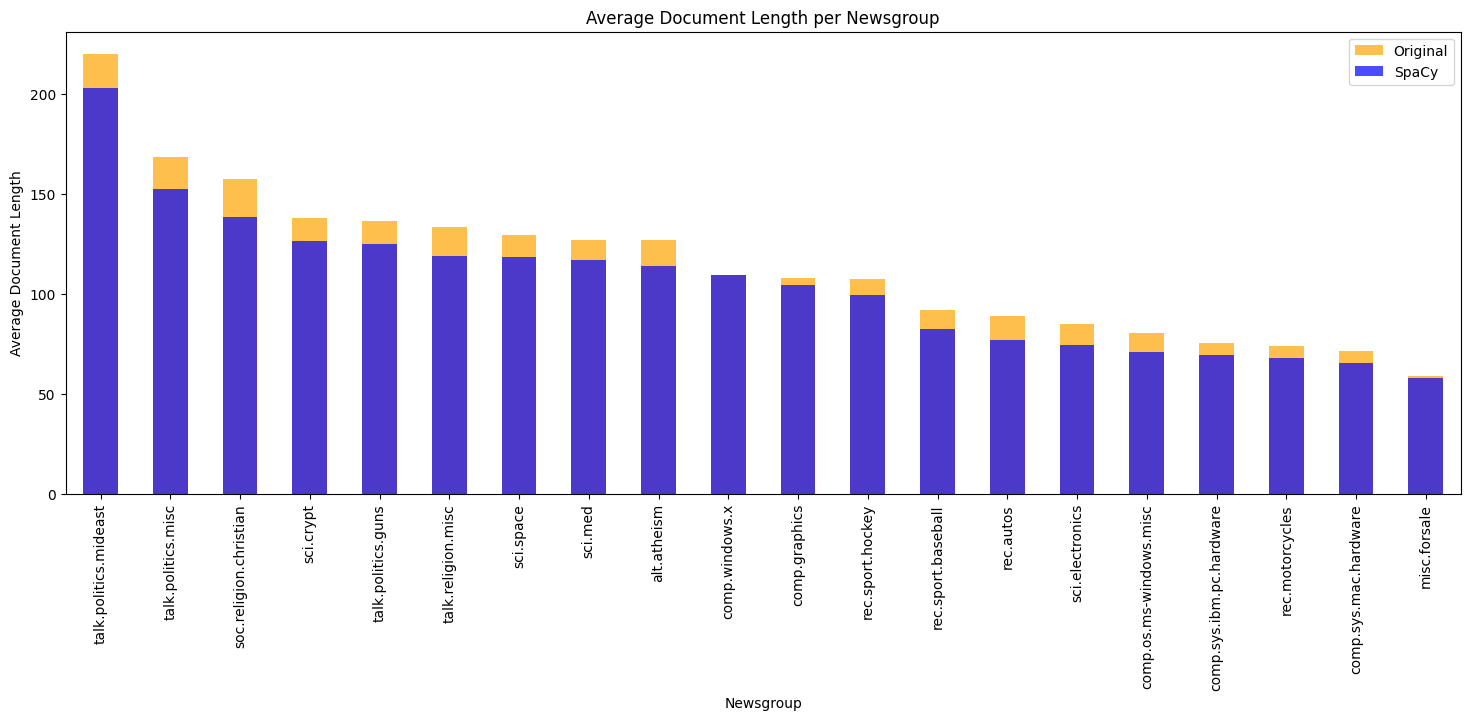

In [50]:
# Display average document length per newsgroup
avg_doc_length_per_group = df.groupby('Newsgroup')['Prep_Document_Length'].mean().sort_values(ascending=False)
plt.figure(figsize=(18, 6))
avg_doc_length_per_group.plot(kind='bar', color='orange', alpha=0.7, label='Original')
avg_doc_length_per_group_spacy = df.groupby('Newsgroup')['SpaCy_Document_Length'].mean().sort_values(ascending=False)
avg_doc_length_per_group_spacy.plot(kind='bar', color='blue', alpha=0.7, label='SpaCy')
plt.title('Average Document Length per Newsgroup')
plt.xlabel('Newsgroup')
plt.ylabel('Average Document Length')
plt.xticks(rotation=90)
plt.legend()
plt.show()